# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

More detail in the writeup report. Rubric: [link](https://review.udacity.com/#!/rubrics/1966/view)

## Import libraries

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Classes

In [9]:
class Lane():
    def __init__(self):
        # Constants
        self.y1 = 600
        self.xdiff = 600
        # First run?
        self.first = True  
        # Was the line detected in the last iteration?
        self.detected = False  
        # Poly fit result in pixel
        self.left_fit_previous = None
        self.right_fit_previous = None
        # Poly fit result in meter
        self.left_fit_cr_previous = None
        self.right_fit_cr_previous = None
        
    def check(self, left_fit, right_fit, left_fit_cr, right_fit_cr):
        # Do not check for first run (no previous info)
        if self.first == False:
            # Calculate x at y1 eight
            l_x1 = left_fit[0]*self.y1**2 + left_fit[1]*self.y1 + left_fit[2]
            r_x1 = right_fit[0]*self.y1**2 + right_fit[1]*self.y1 + right_fit[2]
            dx = r_x1-l_x1
           
            # If there is not a big difference between x values -> check OK
            check1= (self.xdiff-100<dx) & (dx<self.xdiff+100)

        else:
            self.first = False
            check1 = True   
        if check1:
            self.detected = True
        else:
            self.detected = False
        
        return self.detected

In [3]:
class Pipeline:
    def __init__(self, _mtx, _dist, _M, _Minv):
        self.mtx = _mtx
        self._dist = _dist
        self._M = _M
        self._Minv = _Minv
    def __call__(self, image):
        result = process_image(image, mtx, dist, M, Minv)     
        return result

## Helper functions

In [4]:
def camera_calibration(images, nx, ny):   
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:                # If corners found
            objpoints.append(objp)     # collect info for calibration
            imgpoints.append(corners)  # collect info for calibration

    #Calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

# "Bird's eye view" transformation
def perspective_transform_matrixes(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def region_of_interest(img, vertices):
    """
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Thresholding RGB format image's channel
def rgb_thresh(img, thresh_R=(0, 255), thresh_G=(0,255), thresh_B=(0,255)):
    # 1) Expecting RGB format image
    # 2) Apply a threshold to the channels
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    thresholded_R = np.zeros_like(R)
    thresholded_R[(R > thresh_R[0]) & (R <= thresh_R[1])] = 1
    thresholded_G = np.zeros_like(G)
    thresholded_G[(G > thresh_G[0]) & (G <= thresh_G[1])] = 1
    thresholded_B = np.zeros_like(B)
    thresholded_B[(B > thresh_B[0]) & (B <= thresh_B[1])] = 1
    # 3) Return a binary images
    return thresholded_R, thresholded_G, thresholded_B

# Thresholding HLS format image's channel
def hls_thresh(img, thresh_H=(0, 255), thresh_L=(0,255), thresh_S=(0,255)):
    # 1) Expecting RGB format images, convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the channels
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    thresholded_H = np.zeros_like(H)
    thresholded_H[(H > thresh_H[0]) & (H <= thresh_H[1])] = 1
    thresholded_L = np.zeros_like(L)
    thresholded_L[(L > thresh_L[0]) & (L <= thresh_L[1])] = 1
    thresholded_S = np.zeros_like(S)
    thresholded_S[(S > thresh_S[0]) & (S <= thresh_S[1])] = 1
    # 3) Return a binary images
    return thresholded_H, thresholded_L, thresholded_S

# Define a function to threshold an image for a given range and Sobel kernel
def grad_threshold(img, sobel_kernel=5, mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude, rescale to 8 bit
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Take the absolute value of the gradient direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Apply a threshold, and create a binary image result
    gradmag_thresh =  np.zeros_like(gradmag)
    gradmag_thresh[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    graddir_thresh =  np.zeros_like(absgraddir)
    graddir_thresh[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
    # Return a gradient magnitude, thresholded grad. magnitude (binary) and
    # grad. direction, thresholded grad. direction images
    return gradmag, gradmag_thresh, absgraddir, graddir_thresh

# Thresholding image with color and grad information (one value/pixel)
def combined_info_thresh(img, thresh=(0, 255)):
    # 1) Apply a threshold to the channels
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    # 2) Return a binary images
    return binary_output

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = 255 * np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 6
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If you found > minpix pixels, recenter next window 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane region
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(out_img)
    
    return out_img, left_fit, right_fit, left_fit_cr, right_fit_cr

def measure_curvature_pixels(img, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    # R measured at image maximum y-value, corresponding to the bottom of the image
    y_eval = img.shape[0]
    y_real = y_eval*ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_real + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_real + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_distance(img, left_fit, right_fit):
    '''
    Calculates the distance of the car from the detected lane polynomial functions in pixels.
    Camera mounted at exact center of car.
    '''
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Distance measured at image maximum y-value, corresponding to the bottom of the image
    y_eval = img.shape[0]
    carMid = img.shape[1]/2
    
    # Calculation of R_curve (radius of curvature)
    leftDist = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    rightDist = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    laneMid = (leftDist + rightDist) / 2
    dist = (laneMid - carMid) * xm_per_pix
    
    return dist

def render_lane(image, flag, left_fit, right_fit, M, Minv):
    '''
    Render lanes on a blank picture and transforms it to "camera" point of view 
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    ploty_rev = np.linspace(img.shape[0]-1, 0, img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_fitx_rev = right_fit[0]*ploty_rev**2 + right_fit[1]*ploty_rev + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        right_fitx_rev = 1*ploty_rev**2 + 1*ploty_rev
        
    # Recast the x and y points into usable format for cv2.polyLines() and cv2.fillPoly()
    lpts = np.vstack((left_fitx,ploty)).astype(np.int32).T
    rpts = np.vstack((right_fitx,ploty)).astype(np.int32).T
    rpts_rev = np.vstack((right_fitx_rev,ploty_rev)).astype(np.int32).T
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:]).astype(np.uint8)
    warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(warp,  [lpts],  False,  (0, 0, 255),  30)
    cv2.polylines(warp,  [rpts],  False,  (0, 0, 255),  30)
    area = np.vstack((lpts,rpts_rev))
    if flag:
        area_color = (0, 255, 0)
    else:
        area_color = (255, 0, 0)
    cv2.fillPoly(warp, [area], area_color)

    # Warp the blank back to original image space
    unwarp = cv2.warpPerspective(warp, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    
    return unwarp

## Image Pipeline

In [5]:
def process_image(img, mtx, dist, M, Minv):
    '''
    Expecting RGB image, matrixes for camera calibration and perspective transformation
    '''
    # Undistort test image based on calibration
    undist = cv2.undistort(img, mtx, dist, None, mtx)
       
    # Thresholding image
    threshold_R = (220,255)
    threshold_G = (220,255)
    threshold_B = (0,255)
    threshold_H = (17,40)
    threshold_L = (0,255)
    threshold_S = (150,255)
    thresh_gradmag = (60,255)
    thresh_graddir = (0.7,1.3)
    thresh_warp = (50,255)  # 255/6 steps

    dst_R, dst_G, dst_B = rgb_thresh(undist, threshold_R, threshold_G, threshold_B)
    dst_H, dst_L, dst_S = hls_thresh(undist, threshold_H, threshold_L, threshold_S)
    gm, gradmag_thresh, gd, graddir_thresh = grad_threshold(undist, 15, thresh_gradmag, thresh_graddir)
    
    # Combining color and gradient information
    summa_RGHSgrad = (dst_R + dst_G + dst_H + dst_S + gradmag_thresh + graddir_thresh) * 255 / 6
    #plt.imshow(summa_RGHSgrad)
    
    # Thresholding to suppress noise
    combined_binary = combined_info_thresh(summa_RGHSgrad, thresh_warp)
    #plt.imshow(combined_binary)
    
    # Masking to get Region of Interest 
    ysize = combined_binary.shape[0]
    xsize = combined_binary.shape[1]
    lineWidth = 1200  # Close to car
    yCutOff = ysize/2 + 50 # Cuting off too distant pixels
    vertices = np.array([[(xsize/2 - lineWidth/2,ysize),
                          (xsize/2 - 120, yCutOff),
                          (xsize/2 + 120, yCutOff),
                          (xsize/2 + lineWidth/2,ysize)]], dtype=np.int32)
    imgRoI = region_of_interest(combined_binary, vertices)
    #plt.imshow(imgRoI)
    
    # Perspective transformation ("Bird's eye view")
    img_size = (imgRoI.shape[1], imgRoI.shape[0])
    warped = cv2.warpPerspective(imgRoI, M, img_size, flags=cv2.INTER_LINEAR)
    scale_factor = np.max(warped)/255
    warped2 = (warped/scale_factor).astype(np.uint8)
    #plt.imshow(warped2)
    
    # Fitting polynomials to lanes
    out_img , left_fit, right_fit, left_fit_cr, right_fit_cr = fit_polynomial(warped2)
    
    # Sanity check
    if lane.check(left_fit, right_fit, left_fit_cr, right_fit_cr):
        lane.left_fit_previous = left_fit
        lane.right_fit_previous = right_fit
        lane.left_fit_cr_previous = left_fit_cr
        lane.right_fit_cr_previous = right_fit_cr
        flag = True
    else:
        left_fit = lane.left_fit_previous
        right_fit = lane.right_fit_previous
        left_fit_cr = lane.left_fit_cr_previous
        right_fit_cr = lane.right_fit_cr_previous
        flag = False

    # Measuring curvature and distance from lane center (both in meter)
    leftR, rightR = measure_curvature_pixels(out_img, left_fit_cr, right_fit_cr)
    laneDist = measure_distance(out_img, left_fit, right_fit)

    # Ploting lanes back to the original image
    rendered_lanes = render_lane(warped, flag, left_fit, right_fit, M, Minv)
    result = cv2.addWeighted(undist, 1, rendered_lanes, 0.8, 0)

    # Adding information about lane radiuses and distance from lane center
    cv2.putText(result, "Distance from center: " + str(round(laneDist,2)) + " m", (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255,0,0),3)
    cv2.putText(result, "Left lane radius: " + str(int(leftR)) + " m", (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255,0,0),3)
    cv2.putText(result, "Right lane radius: " + str(int(rightR)) + " m", (20,120), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255,0,0),3)
    return result

## Main program

## Prepare camera calibration and perspective transformation matrixes

In [6]:
# Camera calibration
nx = 9  # Number of corners on x axis of chessboard
ny = 6  # Number of corners on y axis of chessboard
images = glob.glob('camera_cal/calibration*.jpg')  # Calibration images
ret, mtx, dist, rvecs, tvecs = camera_calibration(images,nx,ny)  # Calibration

# "Bird's eye view" transformation matrixes
transform = cv2.imread('test_images/straight_lines1.jpg')
img_size = (transform.shape[1], transform.shape[0])
src = np.float32( [[595,450],[255,685],[685,450],[1050,680]] )
dst = np.float32( [[350,0],[350,img_size[1]],[950,0],[950,img_size[1]]] )
M, Minv = perspective_transform_matrixes(images[0], src, dst)

## Test on Images

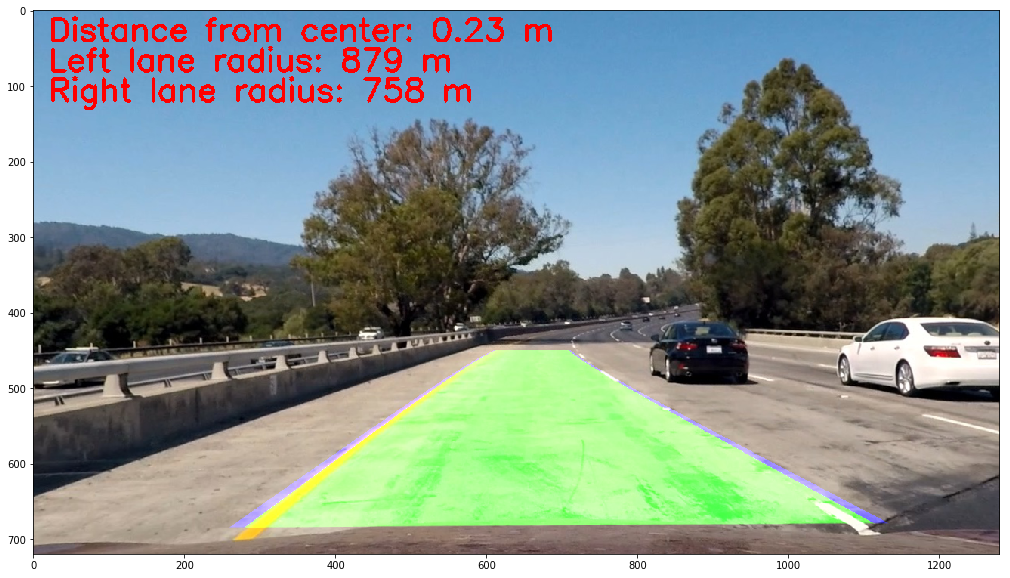

In [10]:
# Setting up sanity check (first run different)
lane = Lane()

#ToDo Replace the images index (0-5) to test image processing pipeline on other images
images = glob.glob('test_images/test*.jpg')  # Test images
img = cv2.imread(images[2])

# Process image
imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV load BGR instead of RGB
sample = process_image(imgrgb, mtx, dist, M, Minv)

# Plot result
plt.figure(figsize=(20,10))
plt.imshow(sample)


## Test on Videos

In [11]:
video_input = 'test_videos/project_video.mp4'
video_output = 'output_videos/project_video.mp4'

# Setting up sanity check (first run different)
lane = Lane()

In [12]:
clip = VideoFileClip(video_input)
video_clip = clip.fl_image(Pipeline(mtx, dist, M, Minv))
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [09:56<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 7min 10s, sys: 37 s, total: 7min 47s
Wall time: 9min 59s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))